## Code Overview

- **`preprocess_image(img)`**: Converts the image to grayscale, applies Gaussian blur, detects edges, and performs dilation and erosion to prepare for contour detection.
  
- **`classify_shape(contour)`**: Classifies the shape based on the number of vertices and geometric properties.
  
- **`is_star(approx)`**: Checks if the shape is a star based on vertex count.
  
- **`crop_and_center(contour, binary_img, padding=10)`**: Crops the contour from the binary image and centers it with padding.
  
- **`rotate_and_smooth(img)`**: Rotates the image to correct for skew and applies Gaussian blur to smooth it.
  
- **`calculate_symmetry(img)`**: Calculates horizontal, vertical, diagonal, and radial symmetry of the image.
  
- **`analyze_image(input_data, input_type='image')`**: Main function that reads the image or polyline, processes contours, classifies shapes, calculates symmetry, and displays the results.

## Parameters

- **`input_data`**: Path to the image file or a list of points for a polyline.
  
- **`input_type`**: Specifies the type of input (`'image'` or `'polyline'`).
  
- **`padding`** (in `crop_and_center`): Amount of padding around the cropped contour.
  
- **Symmetry thresholds** (in `calculate_symmetry`): Adjust the thresholds for symmetry detection if necessary (e.g., `0.2` for horizontal and vertical symmetry, `0.5` for rotational symmetry).


### Imports

**Description**: The following libraries are imported for image processing, numerical operations, and plotting:

- `cv2`: OpenCV library for image processing.
- `numpy`: Library for numerical operations and array manipulation.
- `matplotlib.pyplot`: Library for plotting graphs and displaying images.


In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### `preprocess_image(img)`

**Description**: Converts the input image to grayscale, applies Gaussian blur, detects edges, and performs dilation and erosion to prepare for contour detection.

**Parameters**:
- `img` (ndarray): The input image in BGR format.

**Returns**:
- `contours` (list of ndarray): List of detected contours.
- `eroded_img` (ndarray): The processed binary image after dilation and erosion.


In [82]:
# Function to preprocess the image
def preprocess_image(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    blurred_img = cv2.GaussianBlur(gray_img, (13, 13), 0)  # Apply Gaussian blur to reduce noise
    edges = cv2.Canny(blurred_img, threshold1=50, threshold2=150)  # Edge detection using Canny
    kernel = np.ones((5, 5), np.uint8)  # Structuring element for morphological operations
    dilated_img = cv2.dilate(edges, kernel, iterations=2)  # Dilation to close gaps
    eroded_img = cv2.erode(dilated_img, kernel, iterations=1)  # Erosion to remove noise
    contours, _ = cv2.findContours(eroded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    return contours, eroded_img


### `is_star` Function

```markdown
### `is_star(approx)`

**Description**: Determines if the shape is a star based on the number of vertices.

**Parameters**:
- `approx` (ndarray): Approximation of the contour as a polygon.

**Returns**:
- `bool`: `True` if the shape is a star, otherwise `False`.

In [83]:
def is_star(approx):
    num_vertices = len(approx)
    return num_vertices == 10


### `classify_shape` Function

```markdown
### `classify_shape(contour)`

**Description**: Classifies the shape based on the number of vertices and geometric properties such as aspect ratio and circularity.

**Parameters**:
- `contour` (ndarray): A single contour detected in the image.

**Returns**:
- `shape` (str): The name of the classified shape (e.g., "circle", "rectangle").
- `approx` (ndarray): Approximation of the contour as a polygon.


In [84]:
# Function to classify shape based on contours
def classify_shape(contour):
    peri = cv2.arcLength(contour, True)  # Calculate the perimeter of the contour
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)  # Approximate the contour to a polygon
    num_vertices = len(approx)  # Number of vertices in the approximated polygon

    # Determine shape based on the number of vertices
    if num_vertices == 3:
        shape = "triangle"
    elif num_vertices == 4:
        (x, y, w, h) = cv2.boundingRect(approx)  # Get bounding box of the contour
        ar = w / float(h)  # Aspect ratio of the bounding box
        shape = "square" if 0.95 <= ar <= 1.05 else "rectangle"
    elif num_vertices == 5:
        shape = "pentagon"
    elif num_vertices == 6:
        shape = "hexagon"
    elif num_vertices == 7:
        shape = "heptagon"
    elif num_vertices == 10 and is_star(approx):
        shape = "star"
    else:
        area = cv2.contourArea(contour)  # Area of the contour
        circularity = 4 * np.pi * area / (peri * peri)  # Circularity of the contour
        (x, y), (MA, ma), angle = cv2.fitEllipse(contour)  # Fit an ellipse to the contour
        aspect_ratio = MA / ma  # Aspect ratio of the ellipse

        # Determine if the shape is a circle or ellipse
        if 0.80 <= aspect_ratio <= 1.20 and circularity >= 0.80:
            shape = "circle"
        else:
            shape = "ellipse"
        if num_vertices > 7 and shape not in ["ellipse", "circle"]:
            shape = "polygon"

    return shape, approx



### `crop_and_center` Function

```markdown
### `crop_and_center(contour, binary_img, padding=10)`

**Description**: Crops the contour from the binary image and centers it with padding to create a centered image of the contour.

**Parameters**:
- `contour` (ndarray): A single contour detected in the image.
- `binary_img` (ndarray): The binary image from which the contour is cropped.
- `padding` (int, optional): Amount of padding around the cropped contour (default is 10).

**Returns**:
- `centered_img` (ndarray): The cropped and padded image of the contour.


In [85]:
# Function to crop and center the image around the contour
def crop_and_center(contour, binary_img, padding=10):
    x, y, w, h = cv2.boundingRect(contour)  # Get bounding box of the contour
    cropped_img = binary_img[y:y+h, x:x+w]  # Crop the image
    max_side = max(w, h) + 2 * padding  # Size of the padded image
    centered_img = np.full((max_side, max_side), 255, dtype=np.uint8)  # Create a white canvas
    start_y = (max_side - h) // 2
    start_x = (max_side - w) // 2
    centered_img[start_y:start_y+h, start_x:start_x+w] = cropped_img  # Place the cropped image on the canvas
    return centered_img

### `rotate_and_smooth` Function

```markdown
### `rotate_and_smooth(img)`

**Description**: Rotates the image to correct for skew and applies Gaussian blur to smooth it.

**Parameters**:
- `img` (ndarray): The image to be rotated and smoothed.

**Returns**:
- `rotated_img` (ndarray): The smoothed and rotated image.


In [86]:
# Function to rotate and smooth the image
def rotate_and_smooth(img):
    smoothed_img = cv2.GaussianBlur(img, (3, 3), 0)  # Smooth the image to reduce noise
    moments = cv2.moments(smoothed_img)  # Calculate moments of the image
    if moments['mu20'] == moments['mu02']:
        return smoothed_img  # Return if the image is already aligned
    angle = 0.5 * np.arctan2(2 * moments['mu11'], moments['mu20'] - moments['mu02'])  # Calculate rotation angle
    angle = np.degrees(angle)
    rows, cols = smoothed_img.shape
    center = (cols // 2, rows // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)  # Create rotation matrix
    rotated_img = cv2.warpAffine(smoothed_img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=255)  # Rotate the image
    return rotated_img


### `calculate_symmetry` Function

```markdown
### `calculate_symmetry(img)`

**Description**: Calculates horizontal, vertical, diagonal, and radial symmetry of the image.

**Parameters**:
- `img` (ndarray): The image for symmetry calculation.

**Returns**:
- `h_norm_diff` (float): Normalized difference for horizontal symmetry.
- `v_norm_diff` (float): Normalized difference for vertical symmetry.
- `d_norm_diff` (float): Normalized difference for diagonal symmetry.
- `c_mean_diff` (float): Mean difference for radial symmetry.

In [87]:
# Function to calculate symmetry of the image
def calculate_symmetry(img):
    rows, cols = img.shape
    
    # Horizontal symmetry
    h_flipped_img = cv2.flip(img, 1)  # Flip image vertically
    h_diff = np.abs(img - h_flipped_img)  # Difference between original and flipped image
    h_norm_diff = np.sum(h_diff > 0) / (np.sum(img == 0) + 1e-6)  # Normalized difference

    # Vertical symmetry
    v_flipped_img = cv2.flip(img, 0)  # Flip image horizontally
    v_diff = np.abs(img - v_flipped_img)  # Difference between original and flipped image
    v_norm_diff = np.sum(v_diff > 0) / (np.sum(img == 0) + 1e-6)  # Normalized difference

    # Diagonal symmetry (45 degrees)
    d_rotated_img = rotate_and_smooth(img)  # Rotate and smooth image
    d_flipped_img = cv2.flip(d_rotated_img, 0)  # Flip image horizontally
    d_diff = np.abs(d_rotated_img - d_flipped_img)  # Difference between original and flipped image
    d_norm_diff = np.sum(d_diff > 0) / (np.sum(d_rotated_img == 0) + 1e-6)  # Normalized difference

    # Radial symmetry
    c_diffs = []
    center = (cols // 2, rows // 2)
    for angle in range(0, 360, 2):  # Check for rotation from 0 to 360 degrees
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=255)
        c_diff = np.sum(np.abs(img - rotated_img) > 0) / (np.sum(img == 0) + 1e-6)  # Difference between original and rotated image
        c_diffs.append(c_diff)
    c_mean_diff = np.mean(c_diffs)  # Mean difference for radial symmetry

    return h_norm_diff, v_norm_diff, d_norm_diff, c_mean_diff

### `analyze_image` Function

```markdown
### `analyze_image(input_data, input_type='image')`

**Description**: Main function that reads the image or polyline, processes contours, classifies shapes, calculates symmetry, and displays the results.

**Parameters**:
- `input_data` (str or list of tuples): Path to the image file or a list of points representing a polyline.
- `input_type` (str, optional): Type of input (`'image'` or `'polyline'`). Default is `'image'`.

**Returns**:
- None: Displays results directly.

In [88]:
# Main function to analyze an image or polyline
def analyze_image(input_data, input_type='image'):
    if input_type == 'image':
        img = cv2.imread(input_data)  # Read the image file
        if img is None:
            print(f"Error loading image from path: {input_data}")
            return
        contours, processed_img = preprocess_image(img)  # Preprocess the image
    elif input_type == 'polyline':
        contours = []
        for path in input_data:
            for sub_path in path:
                if sub_path.shape[1] == 2:  # Check if sub_path is already in [x, y] form
                    contours.append(sub_path.astype(np.int32))
                else:
                    raise ValueError("Each sub-path should contain 2D points (x, y).")
        img = np.ones((500, 500, 3), dtype=np.uint8) * 255  # Create a blank canvas for drawing
        processed_img = np.zeros((500, 500), dtype=np.uint8) 

    results = []

    for idx, contour in enumerate(contours):
        shape, approx = classify_shape(contour)  # Classify the shape

        # Debug print for contour vertices
        print(f"Contour {idx + 1} vertices: {len(approx)}")

        # Special handling for circles
        if shape == "circle":
            (x, y), radius = cv2.minEnclosingCircle(contour)  # Find the minimum enclosing circle
            center = (int(x), int(y))
            radius = int(radius)
            # Create a circle approximation
            approx = np.array([[[center[0] + radius * np.cos(theta), center[1] + radius * np.sin(theta)]] for theta in np.linspace(0, 2*np.pi, 100)], dtype=np.int32)

        # Crop and center the contour
        centered_img = crop_and_center(contour, processed_img)
        preprocessed_img = rotate_and_smooth(centered_img)
        h_diff, v_diff, d_diff, c_diff = calculate_symmetry(preprocessed_img)  # Calculate symmetry

        # Determine font size based on number of shapes
        font_scale = 1 if len(contours) > 1 else 0.5

        # Draw shape on the image
        cv2.drawContours(img, [approx], -1, (0, 255, 0), 2)  # Draw contour
        M = cv2.moments(contour)  # Calculate moments for text placement
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.putText(img, shape, (cX - 20, cY + 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), 2)  # Add text label

        # Display the shape and symmetry details
        print(f"Shape {idx + 1}: {shape}")
        print(f"Horizontal Symmetry: {'Exists' if h_diff < 0.2 else 'Does not exist'}")
        print(f"Vertical Symmetry: {'Exists' if v_diff < 0.2 else 'Does not exist'}")
        print(f"Diagonal Symmetry: {'Exists' if d_diff < 0.2 else 'Does not exist'}")
        print(f"Rotational Symmetry: {'Exists' if c_diff < 0.5 else 'Does not exist'}")

    # Save and display the final image with shapes
    output_path = 'output_image_with_shapes.png'
    cv2.imwrite(output_path, img)  # Save the output image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display the image using matplotlib
    plt.title('Detected Shapes and Symmetry')
    plt.axis('off')
    plt.show()


## Example Usage

To analyze a polyline, you can define the polyline vertices and pass them to the `analyze_image` function. Here is a placeholder example:

```python
# Define a sample polyline (replace with your polyline vertices)
polyline = ["Insert the path of the polyline as you want"]

# Analyze the polyline
analyze_image(polyline, input_type='polyline')


Contour 1 vertices: 5
Shape 1: pentagon
Horizontal Symmetry: Does not exist
Vertical Symmetry: Exists
Diagonal Symmetry: Exists
Rotational Symmetry: Exists
Contour 2 vertices: 4
Shape 2: rectangle
Horizontal Symmetry: Exists
Vertical Symmetry: Exists
Diagonal Symmetry: Exists
Rotational Symmetry: Does not exist
Contour 3 vertices: 8
Shape 3: circle
Horizontal Symmetry: Exists
Vertical Symmetry: Exists
Diagonal Symmetry: Exists
Rotational Symmetry: Exists


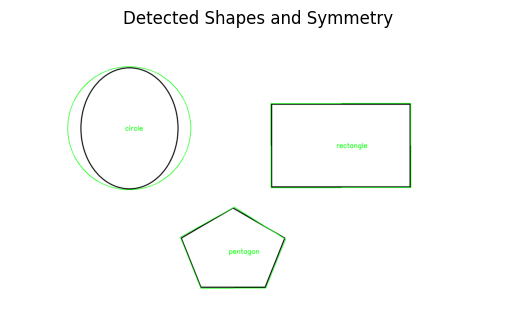

In [89]:
analyze_image(r"C:\Users\Harish Ramaswamy\OneDrive\Desktop\Demo Video\All features in One Run Question.png")

Contour 1 vertices: 4
Shape 1: rectangle
Horizontal Symmetry: Exists
Vertical Symmetry: Exists
Diagonal Symmetry: Does not exist
Rotational Symmetry: Does not exist


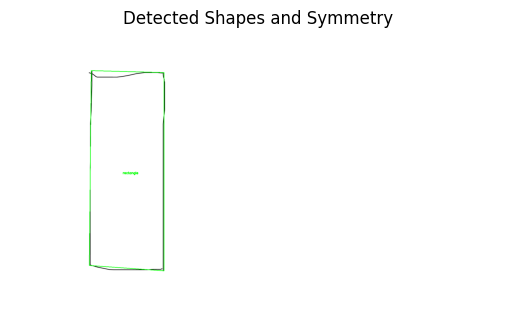

In [90]:
analyze_image(r"C:\Users\Harish Ramaswamy\OneDrive\Desktop\Demo Video\Hand-drawn Rectangle Question.png")

Contour 1 vertices: 10
Shape 1: star
Horizontal Symmetry: Does not exist
Vertical Symmetry: Does not exist
Diagonal Symmetry: Does not exist
Rotational Symmetry: Does not exist
Contour 2 vertices: 4
Shape 2: rectangle
Horizontal Symmetry: Does not exist
Vertical Symmetry: Does not exist
Diagonal Symmetry: Does not exist
Rotational Symmetry: Does not exist
Contour 3 vertices: 8
Shape 3: circle
Horizontal Symmetry: Does not exist
Vertical Symmetry: Does not exist
Diagonal Symmetry: Does not exist
Rotational Symmetry: Does not exist


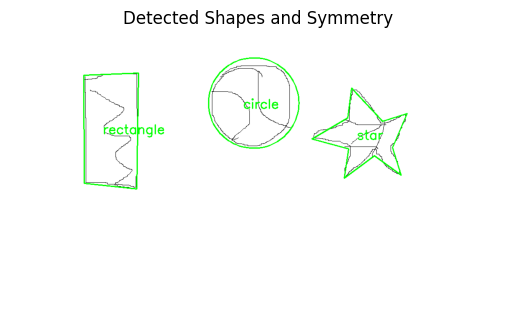

In [91]:
analyze_image(r"C:\Users\Harish Ramaswamy\OneDrive\Desktop\Demo Video\Three Figures in One Question.png")

Contour 1 vertices: 12
Shape 1: ellipse
Horizontal Symmetry: Does not exist
Vertical Symmetry: Does not exist
Diagonal Symmetry: Does not exist
Rotational Symmetry: Does not exist
Contour 2 vertices: 10
Shape 2: star
Horizontal Symmetry: Does not exist
Vertical Symmetry: Does not exist
Diagonal Symmetry: Does not exist
Rotational Symmetry: Does not exist
Contour 3 vertices: 14
Shape 3: ellipse
Horizontal Symmetry: Does not exist
Vertical Symmetry: Does not exist
Diagonal Symmetry: Does not exist
Rotational Symmetry: Does not exist
Contour 4 vertices: 12
Shape 4: ellipse
Horizontal Symmetry: Does not exist
Vertical Symmetry: Does not exist
Diagonal Symmetry: Does not exist
Rotational Symmetry: Does not exist
Contour 5 vertices: 12
Shape 5: ellipse
Horizontal Symmetry: Does not exist
Vertical Symmetry: Does not exist
Diagonal Symmetry: Does not exist
Rotational Symmetry: Does not exist
Contour 6 vertices: 10
Shape 6: star
Horizontal Symmetry: Does not exist
Vertical Symmetry: Does not ex

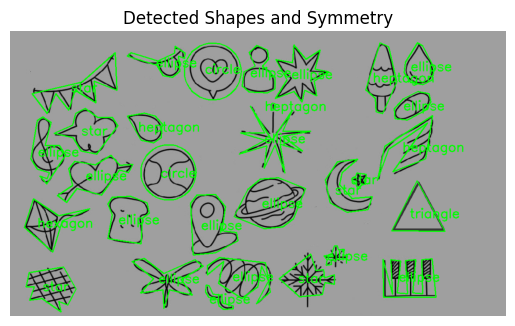

In [102]:
analyze_image(r"C:\Users\Harish Ramaswamy\OneDrive\Desktop\Final Boss.png")

Contour 1 vertices: 13
Shape 1: ellipse
Horizontal Symmetry: Does not exist
Vertical Symmetry: Does not exist
Diagonal Symmetry: Does not exist
Rotational Symmetry: Does not exist


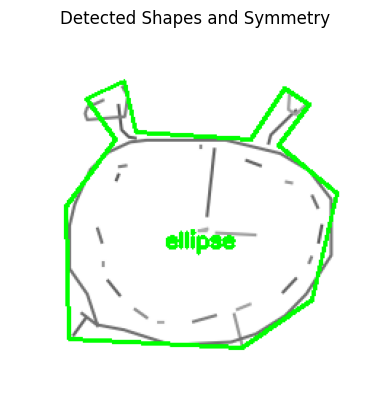

In [92]:
analyze_image(r"C:\Users\Harish Ramaswamy\OneDrive\Desktop\Images\circle2.png")

Contour 1 vertices: 8
Shape 1: circle
Horizontal Symmetry: Exists
Vertical Symmetry: Exists
Diagonal Symmetry: Exists
Rotational Symmetry: Exists
Contour 2 vertices: 10
Shape 2: star
Horizontal Symmetry: Exists
Vertical Symmetry: Exists
Diagonal Symmetry: Exists
Rotational Symmetry: Exists
Contour 3 vertices: 4
Shape 3: rectangle
Horizontal Symmetry: Exists
Vertical Symmetry: Exists
Diagonal Symmetry: Exists
Rotational Symmetry: Exists


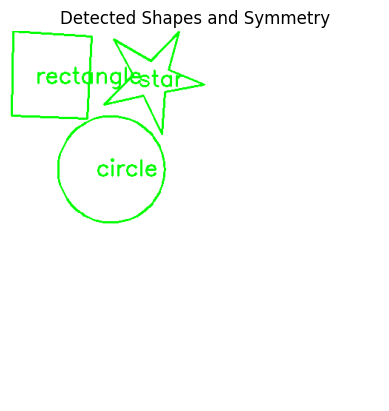

In [93]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

x=read_csv(r"C:\Users\Harish Ramaswamy\OneDrive\Desktop\adobeGensolve-main\adobeGensolve-main\problems\isolated.csv")
analyze_image(x,input_type='polyline')

Contour 1 vertices: 9
Shape 1: ellipse
Horizontal Symmetry: Exists
Vertical Symmetry: Exists
Diagonal Symmetry: Exists
Rotational Symmetry: Does not exist
Contour 2 vertices: 8
Shape 2: ellipse
Horizontal Symmetry: Exists
Vertical Symmetry: Exists
Diagonal Symmetry: Exists
Rotational Symmetry: Does not exist
Contour 3 vertices: 8
Shape 3: circle
Horizontal Symmetry: Exists
Vertical Symmetry: Exists
Diagonal Symmetry: Exists
Rotational Symmetry: Does not exist


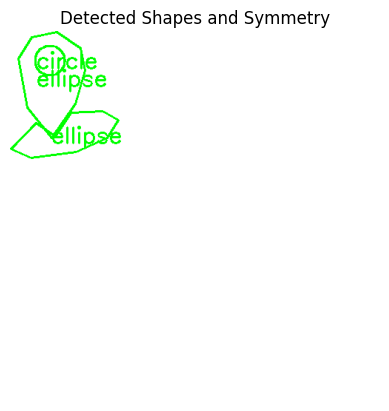

In [101]:
x=read_csv(r"C:\Users\Harish Ramaswamy\OneDrive\Desktop\adobeGensolve-main\adobeGensolve-main\problems\occlusion1.csv")
analyze_image(x,input_type='polyline')

In [94]:
import svgwrite
import cairosvg
colours = ['#FF0000', '#00FF00', '#0000FF', '#00FFFF', '#FF00FF', '#FFFF00','#FFA500', '#800080', '#008080', '#FFC0CB', '#A52A2A', '#000000','#808080', '#00008B', '#00FF00']
def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)
    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile='tiny',
    shape_rendering='crispEdges')
    group = dwg.g()
    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
    group.add(dwg.path(d=path_data, fill=c,
    stroke='none', stroke_width=2))
    dwg.add(group)
    dwg.save()
    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(url=svg_path, write_to=png_path,
    parent_width=W, parent_height=H,
    output_width=fact*W, output_height=fact*H,
    background_color='white')
    return